# The Puerto Rice GeoHealth Notebook

This notebook describes how to:
1. load a Digital Elevation Model (DEM) or Puerto Rico into a *landlab* grid,
1. plot the elevations as an image,
1. dilineate the DEM into separate watersheds,
1. load location data from a file,
1. plot locations and watersheds.

## Read a DEM of Puerto Rico

First, import what we'll need.

In [1]:
%matplotlib inline

import numpy as np
import landlab

To read a DEM from an ESRI ASCII file into a landlab grid, use the `read_esri_ascii` landlab function. The following lines reads elevations from a DEM, creates a landlab `RasterModelGrid` and creates a field, labeled *"topographic__elevation"*, that contains elevations. The elevations are defined at the *nodes* of the grid.

In [2]:
grid, z = landlab.io.read_esri_ascii("data/puerto_rico_filled.asc", name="topographic__elevation")
grid.at_node.keys()

dict_keys(['topographic__elevation'])

For our analysis, we will want to only examine the parts of the grid that are on land. To do this, we mask out all of the elevations that are below sea level by setting them to -999.

In [3]:
ocean = grid.at_node["topographic__elevation"] < 0.
grid.at_node["topographic__elevation"][ocean] = -999.

grid.set_nodata_nodes_to_closed(z, nodata_value=-999.)

Use the `imshow_grid` function to plot the elevations.

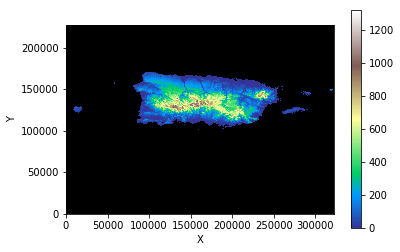

In [4]:
landlab.plot.imshow_grid(grid, "topographic__elevation", cmap="terrain")

# Find watersheds

In this next section, we use landlab to delineate seperate watersheds based on the DEM we just loaded.

In [5]:
from landlab.utils import get_watershed_masks_with_area_threshold
from landlab.components import FlowAccumulator

Before doing the actual delineation, we must route flow over the landscape. This is done with the landlab `FlowAccumulator` component.

*NOTE: This step will probably takes a few minutes to complete*

In [6]:
flow_accumulator = FlowAccumulator(grid, flow_director='D8')
flow_accumulator.run_one_step()

Once the `FlowAccumulator` runs, `get_watershed_masks_with_area_threshold` can be used to define the many watersheds. The resulting array, which is the same size as the DEM, is an array of watershed IDs.

In [7]:
watersheds = get_watershed_masks_with_area_threshold(grid, 8e4)

The following cell defines a helper function that creates a useful colormap that can be used when we create a plot of the watersheds.

In [21]:
def rand_cmap(n_values, select=None):
    import matplotlib.pyplot as plt
    import numpy as np
    
    low, high = 0.6, 0.95
    if select is None:
        colors = np.random.uniform(low=low, high=high, size=n_values * 3).reshape((-1, 3))
    else:
        colors = np.zeros(n_values * 3).reshape((-1, 3))
        colors[select] = np.random.uniform(low=low, high=high, size=len(select) * 3).reshape((-1, 3))

    cmap = plt.cm.colors.ListedColormap(colors)
    cmap.set_under('white')
    
    return cmap

We can now look at the many watersheds that were delineated. There a so many small watersheds that you may need to zoom in to see individual watersheds.

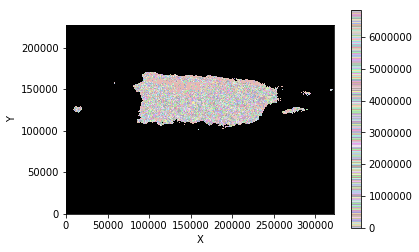

In [9]:
landlab.plot.imshow_grid(
    grid,
    watersheds,
    cmap=rand_cmap(watersheds.max()),
)

## Read sample locations

In this next section, we read in location data from a CSV file, look to see where they are on the grid and then overlay them onto the DEM.

In [10]:
import pandas

In [11]:
data = pandas.read_csv("data/sample_locations.txt")

In [12]:
data

,FID,Count,System,Sample,SampleID,Latitude,Longitude,GeoNetwork
0,0,2.0,D_1,Res,D_1_Res,18.033150,-65.981430,Moved 200m downstream to link upstream of D_2
1,1,14.0,D_2,Res,D_2_Res,18.030945,-65.980139,No change
2,2,24.0,F,Res,F_Res,18.033158,-65.988490,Moved downhill to north network 300 meters
3,3,37.0,B,URes,B_URes,18.077463,-66.051863,Moved douth 100 m - uncertain on side of ridge
4,4,38.0,B,LRes,B_LRes,18.076606,-66.053434,Moved 100m north onto network
5,5,50.0,A,Res,A_Res,18.063904,-66.029455,No change
6,6,63.0,AB,1,AB_1,18.259383,-66.103466,No change
7,7,64.0,AB,2,AB_2,18.258465,-66.094181,No change
8,8,65.0,ABCG,3,ABCG_3,18.256978,-66.065114,No change
9,9,66.0,CG,4,CG_4,18.259921,-66.026112,No change


Note that the location data are expressed as *lat*-*lon* but the grid node coordinates are in meters (you can double check this by looking at values in the *grid.x_of_node* and *grid.y_of_node* arrays).

To map the *lat*-*lon* locations, we can use the `pyproj` package.

In [14]:
import pyproj

The following projection string is for Puerto Rico.

In [15]:
proj = pyproj.Proj('+proj=utm +zone=20N +ellps=WGS84')

Get the *x-y* locations from *lat-lon* and find the IDs of the nodes that are closest to these locations.

In [17]:
xy_of_location = proj(data["Longitude"].values, data["Latitude"].values)
id_of_location = grid.find_nearest_node(proj(data["Longitude"].values, data["Latitude"].values))

With the node IDs we can look at the elevations at those locations.

In [18]:
grid.at_node["topographic__elevation"][id_of_location]

array([ 460.525   ,  401.6872  ,  461.0269  ,  386.8622  ,  336.8474  ,
        253.0092  ,  243.0343  ,  211.5359  ,   86.92188 ,   53.07581 ,
         47.18911 ,   97.28863 ,   25.48574 ,   10.59097 ,    9.374895,
        311.4903  ,  101.6129  ,   72.51905 ,  276.0992  ,  210.8874  ,
        171.8296  ,  110.554   ,  106.6357  ,  101.6953  ,   64.15204 ,
         64.26633 ])

Or we can see the IDs of the watersheds that they are contained in.

In [19]:
watersheds[id_of_location]

array([4605284, 4508562, 4576589, 4802206, 4802206, 4737758, 5615272,
       5615280, 5604575, 5611778, 5611784, 4508562, 4393911, 4393911,
       4393911, 4669725, 4576589, 4576589, 4802206, 4773549, 4752065,
       4676857, 4648204, 4594477, 4576570, 4555092])

Again plot the watersheds but this time just color the watersheds that contain the given locations.

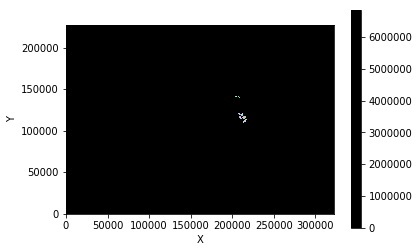

In [22]:
landlab.plot.imshow_grid(
    grid,
    watersheds,
    cmap=rand_cmap(watersheds.max(), select=watersheds[id_of_location]),
)